In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import ipywidgets
# Modules for interactive plotting
import bokeh.plotting
import bokeh.io
bokeh.io.output_notebook()
from IPython.display import display
import os


%matplotlib notebook

Loading BokehJS ...

In [2]:
# Note: data file source from https://github.com/nsteinme/steinmetz-et-al-2019/wiki/data-files
directory = 'Radnitz_2017-01-08/'
locations = pd.read_csv(directory + 'channels.brainLocation.tsv', sep='\t')


In [3]:
# Import data
# Spike-related variables
spikes_times = np.load(os.path.join(directory, 'spikes.times.npy'))[:,0]
spikes_depths = np.load(os.path.join(directory, 'spikes.depths.npy'))[:,0]
spikes_amps = np.load(os.path.join(directory, 'spikes.amps.npy'))[:,0]
spikes_clusters = np.load(os.path.join(directory, 'spikes.clusters.npy'))[:,0]

# Trial-related variables
trials_feedback_times = np.load(os.path.join(directory, 'trials.feedback_times.npy'))[:,0]
trials_feedback_types = np.load(os.path.join(directory, 'trials.feedbackType.npy'))[:,0]
trials_gocue_times = np.load(os.path.join(directory, 'trials.goCue_times.npy'))[:,0]
trials_included = np.load(os.path.join(directory, 'trials.included.npy'))[:,0]
trials_start = np.load(os.path.join(directory, 'trials.intervals.npy'))[:,0]
trials_end = np.load(os.path.join(directory, 'trials.intervals.npy'))[:,1]
trials_repNum = np.load(os.path.join(directory, 'trials.repNum.npy'))[:,0]
trials_choice = np.load(os.path.join(directory, 'trials.response_choice.npy'))[:,0]
trials_response_times = np.load(os.path.join(directory, 'trials.response_times.npy'))[:,0]
trials_left_contrast = np.load(os.path.join(directory, 'trials.visualStim_contrastLeft.npy'))[:,0]
trials_right_contrast = np.load(os.path.join(directory, 'trials.visualStim_contrastRight.npy'))[:,0]
trials_stim_times = np.load(os.path.join(directory, 'trials.visualStim_times.npy'))[:,0]

# Cluster information
clusters_annotation = np.load(os.path.join(directory, 'clusters._phy_annotation.npy'))[:,0]
clusters_peakChannel = np.load(os.path.join(directory, 'clusters.peakChannel.npy'))[:,0]
clusters_brainLoc = locations.allen_ontology[clusters_peakChannel]

In [4]:
# Find 'good' clusters
print('Displaying good manually labelled clusters (top 100):')
np.where(clusters_annotation >= 2)[0][:100]

Displaying good manually labelled clusters (top 100):


array([  2,   5,  12,  13,  15,  18,  19,  22,  23,  26,  27,  28,  29,
        31,  34,  36,  37,  38,  40,  42,  44,  48,  52,  55,  56,  57,
        58,  60,  63,  64,  65,  68,  80,  83,  85,  86,  88,  89,  92,
        96,  98, 100, 105, 106, 107, 110, 114, 117, 118, 121, 122, 125,
       128, 129, 130, 131, 134, 135, 136, 138, 141, 143, 145, 153, 155,
       160, 166, 168, 175, 182, 189, 190, 191, 195, 199, 201, 202, 204,
       208, 209, 211, 212, 216, 218, 219, 221, 223, 226, 228, 233, 236,
       238, 242, 248, 251, 253, 254, 256, 258, 261], dtype=int64)

In [5]:
spikes_fr = pd.DataFrame({'times': spikes_times, 'depths': spikes_depths, 'amps': spikes_amps,
                          'clusters': spikes_clusters})
trials_fr = pd.DataFrame({'feedbackTimes': trials_feedback_times, 'feedbackType': trials_feedback_types,
                         'gocueTimes': trials_gocue_times, 'included': trials_included,
                         'start': trials_start, 'end': trials_end, 'repNum': trials_repNum,
                         'choice': trials_choice, 'response_times': trials_response_times,
                         'leftContrast': trials_left_contrast, 'rightContrast': trials_right_contrast,
                         'stimTimes': trials_stim_times})
clusters_fr = pd.DataFrame({'id': np.arange(len(clusters_annotation)), 'annotation': clusters_annotation, 
                            'brainLoc': clusters_brainLoc, 'peakChannel': clusters_peakChannel})

trials_fr['signedContrast'] = trials_fr.leftContrast - trials_fr.rightContrast

ncells = spikes_fr.clusters.unique().max() + 1

In [6]:
trials_fr.head()

,feedbackTimes,feedbackType,gocueTimes,included,start,end,repNum,choice,response_times,leftContrast,rightContrast,stimTimes,signedContrast
0,41.292039,1.0,41.148036,True,39.535837,42.256580,1.0,1.0,41.254635,1.00,0.00,40.254021,1.00
1,50.556601,1.0,50.367798,True,43.255557,51.524418,1.0,1.0,50.520903,0.50,0.25,49.220578,0.25
2,58.189935,1.0,58.022732,True,52.520271,59.159520,1.0,-1.0,58.153744,0.25,1.00,57.520323,-0.75
3,63.638430,1.0,62.393208,True,60.153976,64.606675,1.0,1.0,63.603413,0.25,0.00,61.269989,0.25
4,69.489733,1.0,69.242928,True,65.603947,70.457130,1.0,1.0,69.453177,1.00,0.00,68.052908,1.00


In [7]:
np.unique(trials_fr.leftContrast)

array([0.  , 0.25, 0.5 , 1.  ])

In [8]:
leftChoiceTrials = np.where(trials_fr['choice'] == 1.0)[0]
rightChoiceTrials = np.where(trials_fr['choice'] == -1.0)[0]
correctTrials = np.where(trials_fr['feedbackType'] == 1.0)[0]
incorrTrials = np.where(trials_fr['feedbackType'] == -1.0)[0]
hardTrials = np.where((trials_fr['leftContrast'] <= 0.25) & (trials_fr['rightContrast'] <= 0.25))[0]
easyTrials = np.where((trials_fr['leftContrast'] > 0.25) | (trials_fr['rightContrast'] > 0.25))[0]

In [9]:
np.unique(clusters_fr.brainLoc)

array(['ACA', 'DP', 'ILA', 'MOs', 'MRN', 'PL', 'RSP', 'SCig', 'SCsg',
       'TT', 'VISp', 'root'], dtype=object)

In [10]:
def find_cluster_by_area(clusters_fr, area):
    '''
    clusters_fr: a frame of clusters
    area: a string indicating brain area
    Return a np array of good clusters (area and annotation >=2)
    '''
    good_clusters = clusters_fr[(clusters_fr.brainLoc == area) & (clusters_fr.annotation >= 2)].id
    return np.array(good_clusters)
    
areas = ['ACA', 'VISp', 'SCig', 'LP']
area_dict = {}
for area in areas:
    good_clusters = find_cluster_by_area(clusters_fr, area)
    area_dict[area] = good_clusters


### Get the overall activity statistics
Here, we try to understand how 'active' the ACC or VC neurons are

In [11]:
cell_nspikes = []
for cellid in area_dict['ACA']:
    nspikes = np.sum(spikes_fr.clusters == cellid)
    #nspikes = spike_cell.shape[0]
    cell_nspikes.append(nspikes)
cell_nspikes = np.array(cell_nspikes)

<IPython.core.display.Javascript object>


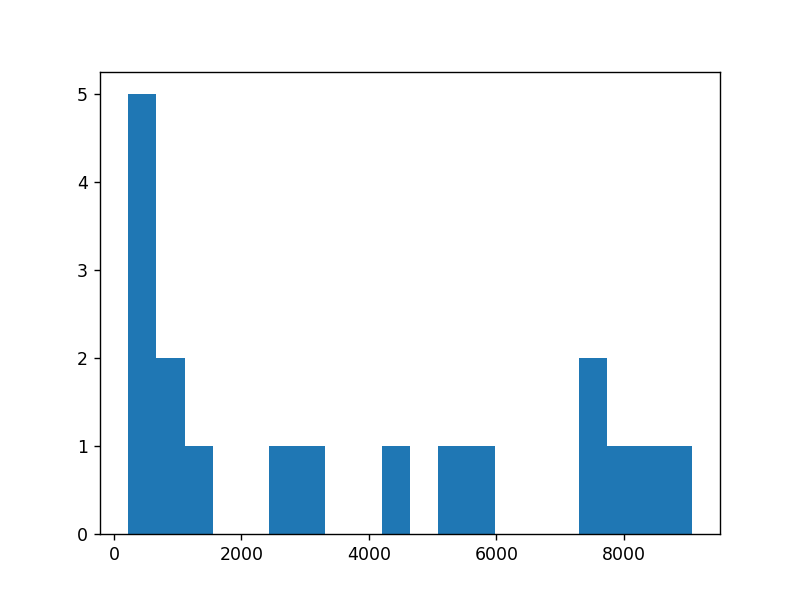

(array([5., 2., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 2.,
        1., 1., 1.]),
 array([ 224. ,  666.2, 1108.4, 1550.6, 1992.8, 2435. , 2877.2, 3319.4,
        3761.6, 4203.8, 4646. , 5088.2, 5530.4, 5972.6, 6414.8, 6857. ,
        7299.2, 7741.4, 8183.6, 8625.8, 9068. ]),
 <a list of 20 Patch objects>)

In [12]:
plt.figure()
plt.hist(cell_nspikes[cell_nspikes < 10000], 20)

In [13]:
# Extract spikes of cluster 300
spike_300 = spikes_fr[spikes_fr.clusters == 10]
trials_fr.head()

,feedbackTimes,feedbackType,gocueTimes,included,start,end,repNum,choice,response_times,leftContrast,rightContrast,stimTimes,signedContrast
0,41.292039,1.0,41.148036,True,39.535837,42.256580,1.0,1.0,41.254635,1.00,0.00,40.254021,1.00
1,50.556601,1.0,50.367798,True,43.255557,51.524418,1.0,1.0,50.520903,0.50,0.25,49.220578,0.25
2,58.189935,1.0,58.022732,True,52.520271,59.159520,1.0,-1.0,58.153744,0.25,1.00,57.520323,-0.75
3,63.638430,1.0,62.393208,True,60.153976,64.606675,1.0,1.0,63.603413,0.25,0.00,61.269989,0.25
4,69.489733,1.0,69.242928,True,65.603947,70.457130,1.0,1.0,69.453177,1.00,0.00,68.052908,1.00


In [14]:
spike_300.shape[0]

615

In [15]:
spike_300

,times,depths,amps,clusters
5750,0.443900,748.726746,159.595013,10
14846,3.165933,729.600403,174.857322,10
52519,13.740333,745.500122,114.620791,10
620594,173.390200,742.000732,149.052065,10
758483,214.561767,749.375732,143.089530,10
...,...,...,...,...
11522449,3104.964400,727.681274,92.569973,10
11522553,3105.000900,734.299011,138.508937,10
11522687,3105.030567,725.938721,105.155355,10
11522749,3105.049433,711.129150,110.266457,10


<IPython.core.display.Javascript object>


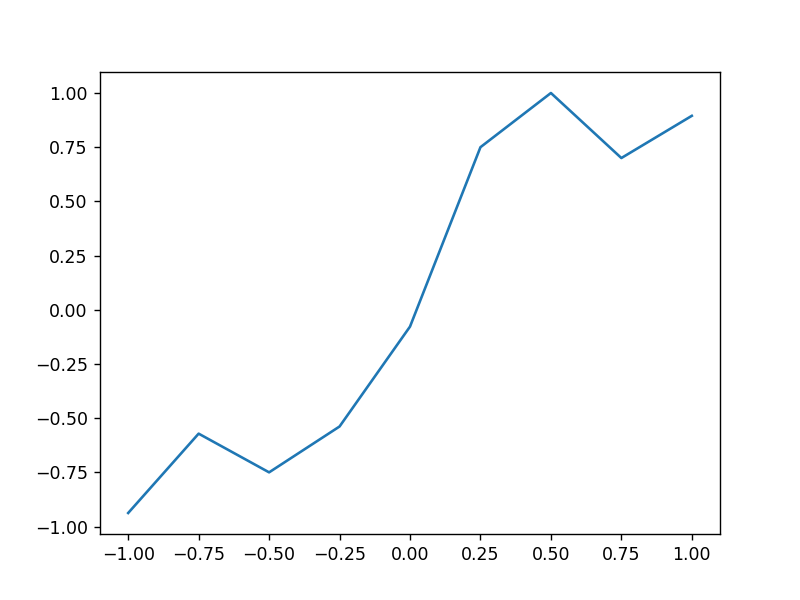

In [16]:
# Plot psychometric curve for this session
performance = trials_fr.groupby(['signedContrast'])['choice'].mean()
plt.figure()
plt.plot(performance)

In [17]:
spike_300.head()

,times,depths,amps,clusters
5750,0.443900,748.726746,159.595013,10
14846,3.165933,729.600403,174.857322,10
52519,13.740333,745.500122,114.620791,10
620594,173.390200,742.000732,149.052065,10
758483,214.561767,749.375732,143.089530,10


In [18]:
# Align all rasters to visual stimulus onset
def splitSpikeTimesToTrials(spikes, tstarts, tends):
    '''
    spikes: the spikes array (nspikes)
    tstarts: trial start times array (ntrials)
    tends: trial end times array (ntrials)
    Returns a list of grouped spike times, ntrials sublists
    '''
    spikeTrialTimes = []
    for i in range(len(tstarts)):
        spikeTrial = spikes[(spikes > tstarts[i]) & (spikes < tends[i])]
        spikeTrialTimes.append(spikeTrial)
        
    return spikeTrialTimes
    
# Perform binning
def BinSpikeTimes(spikes, tstarts, window, nbins):
    '''
    spikes: an array of spike times, split into trials
    tstarts: trial start times (ntrials)
    window: [start, end], window to visualize from start to end
    binwidth: width of bin 
    Returns an nbins x ntrials array of spike counts
    '''
    spikeBinnedCounts = []
    for i in range(len(tstarts)):
        spikeTrial = spikes[(spikes > tstarts[i] + window[0]) & (spikes < tstarts[i] + window[1])]
        
        # Bin
        edges = np.linspace(tstarts[i] + window[0], tstarts[i] + window[1], nbins)
        counts, times = np.histogram(spikeTrial, bins=edges)
        spikeBinnedCounts.append(counts)
               
    return edges[:-1], np.array(spikeBinnedCounts)
        
    
def plot_binned_spikes(cluster_id, area, aligned_by, window, nbins):
    if area != 'None':
        cellid = area_dict[area][cluster_id]
    else:
        cellid = cluster_id
    spike_cluster = spikes_fr[spikes_fr.clusters == cellid]
    nspikes = np.sum(spikes_fr.clusters == cellid)
    print(locations.allen_ontology[clusters_peakChannel[cellid]])
    print('Good', area, 'cell number', cluster_id, ', corresponding to unit #', cellid)
    print('Number of spikes = ', nspikes)
    #print(spike_cluster.times[:100])
    
    if aligned_by == 'default':
        edges1, binned_activity1 = BinSpikeTimes(spike_cluster.times, trials_fr.stimTimes, window, nbins)
        edges2, binned_activity2 = BinSpikeTimes(spike_cluster.times, trials_fr.response_times, window, nbins)
        edges3, binned_activity3 = BinSpikeTimes(spike_cluster.times, trials_fr.feedbackTimes, window, nbins)
    elif aligned_by == 'choice':
        edges1, binned_activity1 = BinSpikeTimes(spike_cluster.times, trials_fr.response_times, window, nbins)
        binnedActivityLeft = binned_activity1[leftChoiceTrials]
        binnedActivityRight = binned_activity1[rightChoiceTrials]
        titleL = 'Left choice'
        titleR = 'Right choice'
    elif aligned_by == 'feedback':
        edges1, binned_activity1 = BinSpikeTimes(spike_cluster.times, trials_fr.feedbackTimes, window, nbins)
        binnedActivityLeft = binned_activity1[correctTrials]
        binnedActivityRight = binned_activity1[incorrTrials]
        titleL = 'Correct'
        titleR = 'Incorrect'
    elif aligned_by == 'difficulty':
        edges1, binned_activity1 = BinSpikeTimes(spike_cluster.times, trials_fr.feedbackTimes, window, nbins)
        binnedActivityLeft = binned_activity1[easyTrials]
        binnedActivityRight = binned_activity1[hardTrials]
        titleL = 'Easy'
        titleR = 'Difficult'
        
    if aligned_by == 'default':
        plt.figure(figsize=(10, 5))
        plt.subplot(131)
        plt.imshow(np.flipud(binned_activity1), cmap='Greys', vmin=0, vmax=1, 
                   extent=[window[0], window[1], 0, binned_activity1.shape[0]], aspect='auto')
        plt.title('Stimulus')

        plt.subplot(132)
        plt.imshow(np.flipud(binned_activity2), cmap='Greys', vmin=0, vmax=1, 
                   extent=[window[0], window[1], 0, binned_activity2.shape[0]], aspect='auto')
        plt.title('Response')

        plt.subplot(133)
        plt.imshow(np.flipud(binned_activity3), cmap='Greys', vmin=0, vmax=1, 
                   extent=[window[0], window[1], 0, binned_activity3.shape[0]], aspect='auto')
        plt.title('Feedback')
    elif aligned_by in ['choice', 'feedback', 'difficulty']:
        plt.figure(figsize=(8, 4))
        plt.subplot(121)
        plt.imshow(np.flipud(binnedActivityLeft), cmap='Greys', vmin=0, vmax=1, 
                   extent=[window[0], window[1], 0, binnedActivityLeft.shape[0]], aspect='auto')
        plt.title(titleL)
        plt.ylim([0, 200])
        
        plt.subplot(122)
        plt.imshow(np.flipud(binnedActivityRight), cmap='Greys', vmin=0, vmax=1, 
                   extent=[window[0], window[1], 0, binnedActivityRight.shape[0]], aspect='auto')
        plt.title(titleR)
        plt.ylim([0, 200])
    else:
        raise ValueError('Invalid alignment')
        
    
    

    
    #return binned_activity
    

In [19]:
#plot_binned_spikes(10, 'ACA', aligned_by='LR choice', window=[-1, 3], nbins=400)

In [20]:
def update(align_by, area, cell=0, window=[-1, 3]):
    # Find allen brain region
    plot_binned_spikes(cell, area, aligned_by=align_by, window=window, nbins=400)
    
    
    
ipywidgets.interactive(update, 
                       cell=ipywidgets.widgets.BoundedIntText(
                            value=0,
                            min=0,
                            max=ncells,
                            step=1,
                            description='CellID: ',
                            disabled=False),
                      window=ipywidgets.widgets.FloatRangeSlider(
                            value=[-1, 3],
                            min=-4,
                            max=4,
                            step=0.1,
                            description='Window (s):',
                            disabled=False,
                            continuous_update=False,
                            orientation='horizontal',
                            readout=True,
                            readout_format='.1f'),
                       area=ipywidgets.widgets.RadioButtons(
                            options=areas + ['None'],
                            description='Brain area:',
                            disabled=False),
                    align_by=ipywidgets.widgets.RadioButtons(
                        options=['default', 'choice', 'feedback', 'difficulty'],
                        description='Align by:',
                        disabled=False
))



A Jupyter Widget

In [21]:
binned_activity = np.array([[0, 0, 0, 0, 0],
                           [0.1, 0.1, 0.1, 0.1, 0.1],
                           [0.5, 0.5, 0.5, 0.5, 0.5],
                           [1, 1, 1, 1, 1]])

<IPython.core.display.Javascript object>


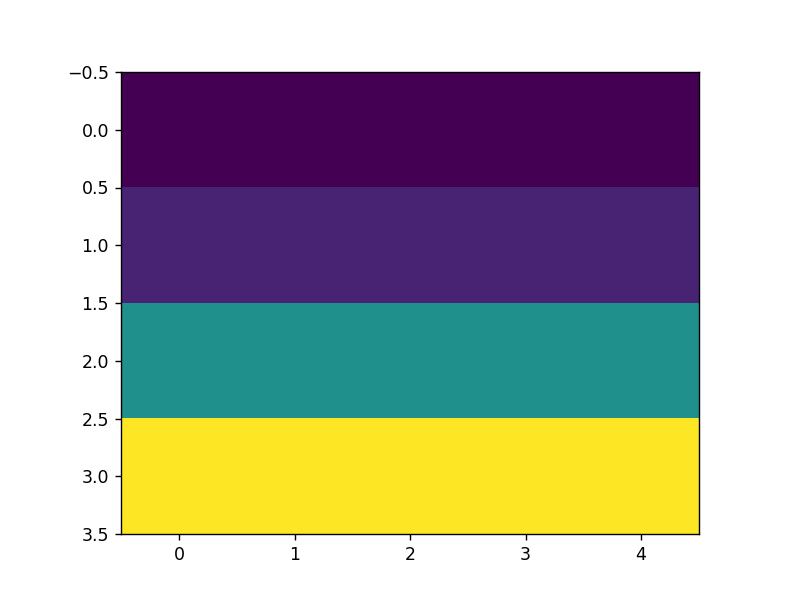

In [22]:
plt.figure()
plt.imshow(binned_activity)
plt.show()